In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from scipy.interpolate import interp1d

## CREATING TARGET POWER SPECTRUM

passiamo per lo spettro di potenza invece che direttamente usare la funzione di correlazione perchè dato che questa è non nulla, la generazione in ogni punto dipende da tutti gli altri punti; nello spazio di fourier invece i modi sono separati

In [2]:
Omega_b = 0.05
omega_c = 0.25

h = 0.7
As = 2.1e-9
ns = 0.96

pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h, ombh2=Omega_b*h**2, omch2=omega_c*h**2)
pars.InitPower.set_params(As=As, ns=ns)

class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.96
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2.1e-09
 At = 1.0
 

In [3]:
pars.set_matter_power(redshifts=[10.], kmax=10.0)
result = camb.get_results(pars)

In [4]:
kh, z, pk = result.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 512)

Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^3]$')

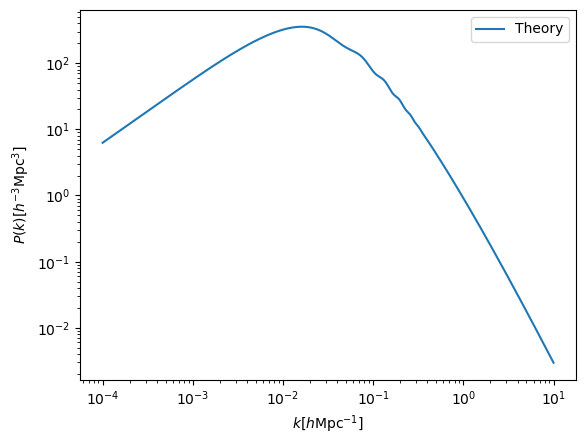

In [5]:
plt.loglog(kh, pk[0], label='Theory')
plt.legend(loc='best')
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")


In [6]:
pk_interpolator = interp1d(kh, pk[0], kind='cubic', fill_value="extrapolate")

## CREATE THE GRID

In [7]:
side = 500
Volume = side**3

n_cells = 100
spacing = side/n_cells

print("grid spacing: ",spacing)

grid spacing:  5.0


In [8]:
kf = 2*np.pi/side # frequenza fondamentale (più piccola frequenza risolvibile)
kN = np.pi/spacing # frequenza di Nyquist (più alta frequenza risolvibile)

print("kf: ",kf, "h/Mpc")
print("kN: ",kN, "h/Mpc")

kf:  0.012566370614359173 h/Mpc
kN:  0.6283185307179586 h/Mpc


In [9]:
kx = np.fft.fftfreq(n_cells, spacing)*2*np.pi  # ha valori positivi crescenti fino alla metà e poi negativi sempre crescenti nella seconda metà
ky = np.fft.fftfreq(n_cells, spacing)*2*np.pi
kz = np.fft.rfftfreq(n_cells, spacing)*2*np.pi # perchè il segnale è reale, così velocizziamo il codice (perchè servono la metà dei punti)

print("kx shape: ",kx.shape)
print("ky shpae: ",ky.shape)
print("kz shape: ",kz.shape)

kx shape:  (100,)
ky shpae:  (100,)
kz shape:  (51,)


In [10]:
kx = np.fft.fftshift(kx) # per avere array ordinato crescente
ky = np.fft.fftshift(ky)

## generate random field in fourier space

In [11]:
pks = np.zeros((n_cells,n_cells,n_cells//2+1))

print(pks.shape)

(100, 100, 51)


In [12]:
# per ogni punto della griglia in k calcoliamo lo spettro di potenza nel valore del modulo di k

for i in range(n_cells):
    
    kx = i if i<= n_cells//2 else i-n_cells
    kx *= 2*np.pi/side

    for j in range(n_cells):
        ky = j if j<= n_cells//2 else j-n_cells
        ky *= 2*np.pi/side

        for k in range(n_cells//2+1):
            kz = k*2*np.pi/side
            knorm = np.sqrt(kx**2 + ky**2 + kz**2)

            pks[i,j,k] = pk_interpolator(knorm)

per ogni punto griglia bisogna generarsi una fase e un punto che segue una gaussiana e moltiplicata per un fattore f=sqrt((V*P(k))/2)

In [13]:
# generate random fields

phase = np.random.uniform(size=pks.shape)*2*np.pi # fase random

delta_k_norms = np.random.normal(size=pks.shape)*np.sqrt(Volume*pks) # modulo di delta_k ##ATTENZIONE CHE QUI NON CI ANDAVA IN /SQRT(2)

delta_k = delta_k_norms*(np.cos(phase) + 1j*np.sin(phase)) # delta_k come numero complesso



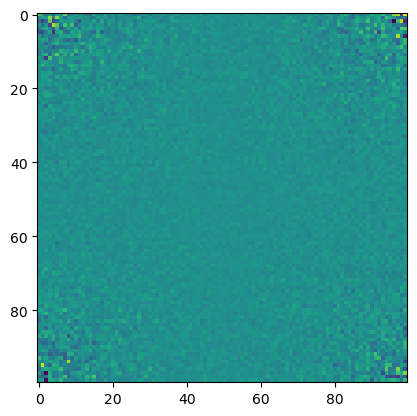

In [14]:
plt.imshow(delta_k_norms[:,:,2])

In [15]:
delta_x = np.fft.irfftn(delta_k, norm='backward')/spacing**3 # trasformata di fourier inversa

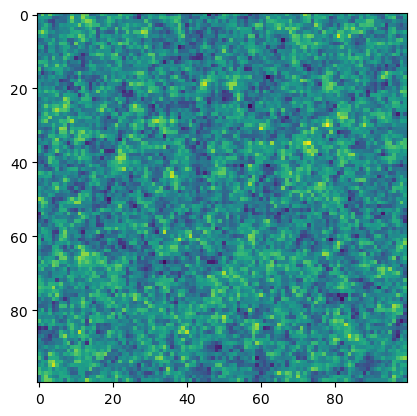

In [16]:
plt.imshow(delta_x[:,:,2]) # è il campo di densità che ha come funzione di correlazione l'antitrasformata di fourier dello spettro di potenza (e media 0)

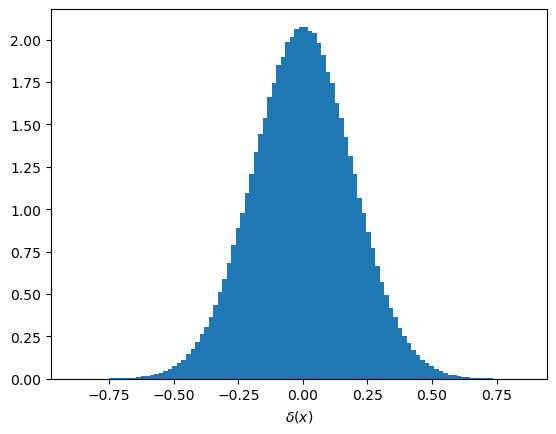

In [17]:
plt.hist(delta_x.flatten(), bins=100, density=True);
plt.xlabel(r"$\delta(x)$");

problema dei campi gauassiani è che danno valori anche dove non ci possono essere, tipo oltre al di fuori dell'intervallo [-1,1] per la densità

In [18]:
mean_delta_x = np.mean(delta_x)
std_delta_x = np.std(delta_x)

print("mean: ", mean_delta_x)
print("std: ", std_delta_x)

mean:  -1.2521297907981543e-05
std:  0.19186319720797973


##  EXTRACT POWER SPECTRUM

In [19]:
# creazione vettori k

kx = np.fft.fftfreq(n_cells, spacing)*2*np.pi
ky = np.fft.fftfreq(n_cells, spacing)*2*np.pi
kz = np.fft.rfftfreq(n_cells, spacing)*2*np.pi

In [20]:
# calcolo modulo di k

knorm = []
for i in range(n_cells):
    
    kx = i if i<= n_cells//2 else i-n_cells
    kx *= 2*np.pi/side

    for j in range(n_cells):
        ky = j if j<= n_cells//2 else j-n_cells
        ky *= 2*np.pi/side

        for k in range(n_cells//2+1):
            kz = k*2*np.pi/side
            knorm.append(np.sqrt(kx**2 + ky**2 + kz**2))

In [21]:
# calcolo spettro di potenza come modulo quadro delle fluttuazioni in spazio di fourier

delta_k_sq = np.abs(delta_k)**2

pks = delta_k_sq.flatten()/Volume

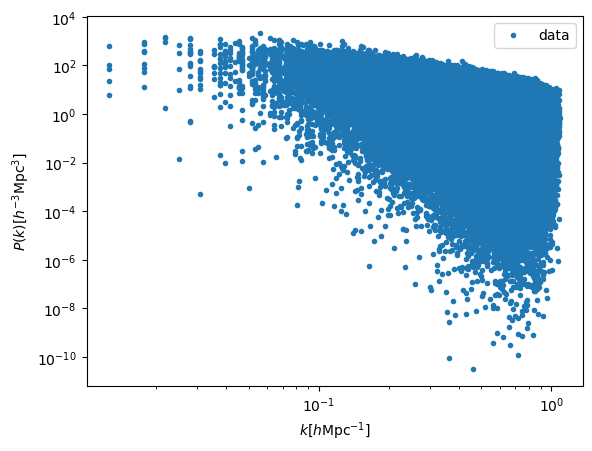

In [22]:
plt.loglog(knorm, pks, ".", label="data")
plt.legend(loc="best")
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$");
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^{3}]$");

ora si binna lo spettro e si calcola in ogni bin come la media dei valori dello spettro in quel bin

In [23]:
edges = np.arange(kf, kN, kf)

In [24]:
pk_meas = np.zeros(len(edges)-1)
k_bin = (edges[1:]+edges[0:-1])/2

In [25]:
for i in range(len(k_bin)):
    k_selection = np.where((knorm>edges[i]) & (knorm<edges[i+1]))[0]
    pk_meas[i] = np.mean(pks[k_selection])

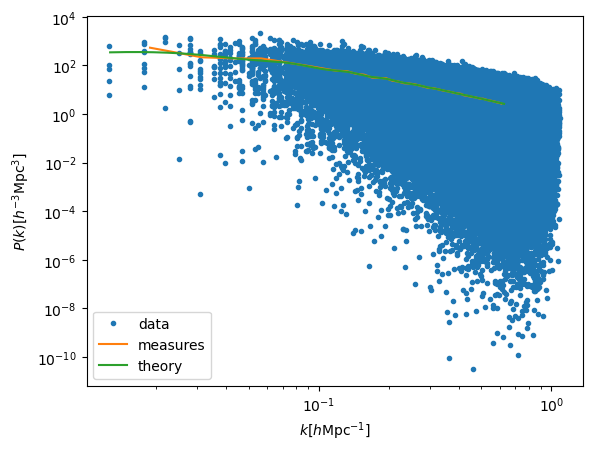

In [26]:
plt.loglog(knorm, pks, ".", label="data")
plt.loglog(k_bin, pk_meas, "-", label="measures")
plt.loglog(kh[(kh>kf) & (kh<kN)], pk[0][(kh>kf) & (kh<kN)], label="theory")
plt.legend(loc="best")
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$");
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^{3}]$");

delta(x) = exp(-sigma^2_g + G(x))-1 con G distribuita gaussianamente sigma è la varianza di G \
csi_g = log(1+csi(r)) con csi(r) = 1/(2pi^2) int[dk k^2 P(k) J_0 (kr)]

In [27]:
knorm = np.reshape(knorm, newshape=(100,100,51)) #perchè knorm alla fine della scorsa lezione era una lista
pks = pk_interpolator(knorm)

In [28]:
# calcolo funzione di correlazione come TF inversa di pks
xi = np.fft.irfftn(pks)/spacing**3

In [29]:
# calcoliamo csi_g
xi_g = np.log(1+xi)

In [30]:
# power spectrum of xi_g
pk_g = np.fft.rfftn(xi_g)*spacing**3 # moltiplicato per lo spacing al cubo per la normalizzazione (si cancella con quello della trasformata)

In [31]:
# G(k)
phase = np.random.uniform(size=pk_g.shape)*2*np.pi

G_k_norm = np.random.normal(size=pk_g.shape)*np.sqrt(Volume*pk_g)
G_k_norm[0,0,0] = 0

G_k = G_k_norm*(np.cos(phase) + 1j*np.sin(phase))

In [32]:
# G(x)
G_x = np.fft.irfftn(G_k, norm='backward')/spacing**3

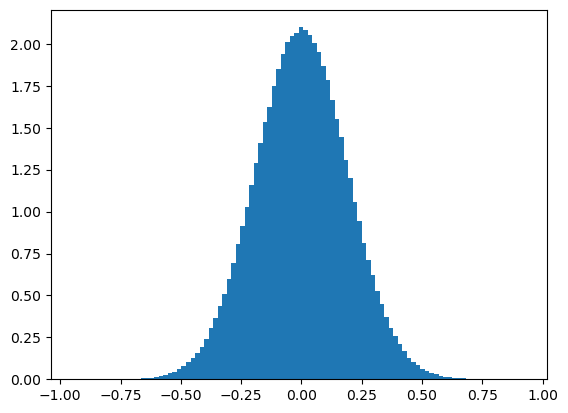

In [33]:
plt.hist(G_x.flatten(), bins=100, density=True, histtype='bar', label='G(x)');

In [34]:
# delta
var_G = np.var(G_x)
delta_x = np.exp(G_x-var_G)-1

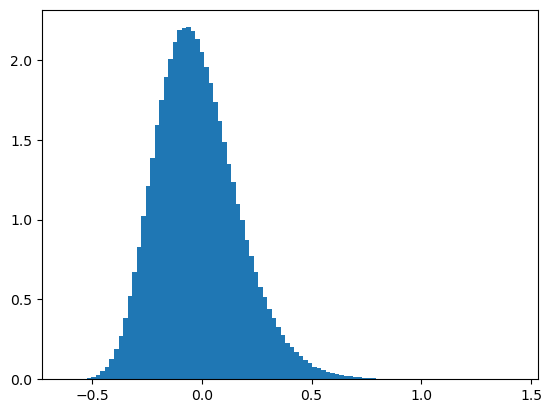

In [35]:
plt.hist(delta_x.flatten(), bins=100, density=True, histtype='bar', label='delta(x)');

per come è definito il campo non possiamo scendere sotto a -1, come vogliamo sia il campo di densità

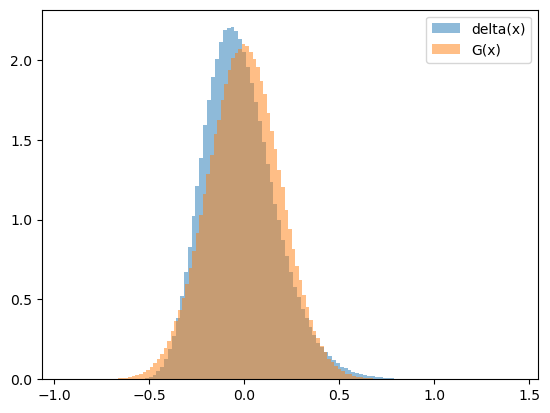

In [36]:
plt.hist(delta_x.flatten(), bins=100, density=True, histtype='bar', label='delta(x)', alpha=0.5); #alpha è per farli venire trasparenti
plt.hist(G_x.flatten(), bins=100, density=True, histtype='bar', label='G(x)', alpha=0.5);
plt.legend(loc='best');

In [39]:
delta_k = np.fft.rfftn(delta_x, norm='backward')*spacing**3

delta_k_sq = np.abs(delta_k)**2

pks = delta_k_sq.flatten()/Volume

pk_meas = np.zeros(len(edges)-1)

k_bin = (edges[1:]+edges[0:-1])/2

for i in range(len(k_bin)):
    k_selection = np.where((knorm.flatten()>edges[i]) & (knorm.flatten()<edges[i+1]))[0]
    pk_meas[i] = np.mean(pks[k_selection])

/tmp/ipykernel_7798/4252932408.py:1: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(k_bin, pk_meas, "-", label="measures", linestyle='dashed')


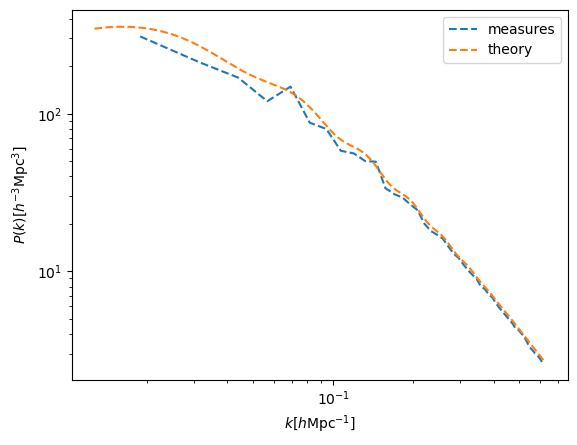

In [40]:
plt.loglog(k_bin, pk_meas, "-", label="measures", linestyle='dashed')
plt.loglog(kh[(kh>kf) & (kh<kN)], pk[0][(kh>kf) & (kh<kN)], label="theory", linestyle='dashed')
plt.legend(loc="best")
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$");
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^{3}]$");